In [1]:
import tensorflow as  tf
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from pathlib import Path

In [2]:
sys.path.append('../utils')

In [3]:
from data_preparing import ChannelData, random_rotation
from model import ChannelCutter
from focal_tversky_loss import *

In [4]:
train_data = ChannelData(
    path=Path('../data/crop_512x320/train'),
    elevation='elevation'
)
val_data = ChannelData(
    path=Path('../data/crop_512x320/val'),
    elevation='elevation'
)
train_data.add_process(random_rotation)
val_data.add_process(random_rotation)

model = ChannelCutter({
    'input_shape': [512, 320, 4],
    'n_classes': 2
})

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile_model(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), 
    loss=generalized_dice_loss, 
    metrics=['accuracy']
)

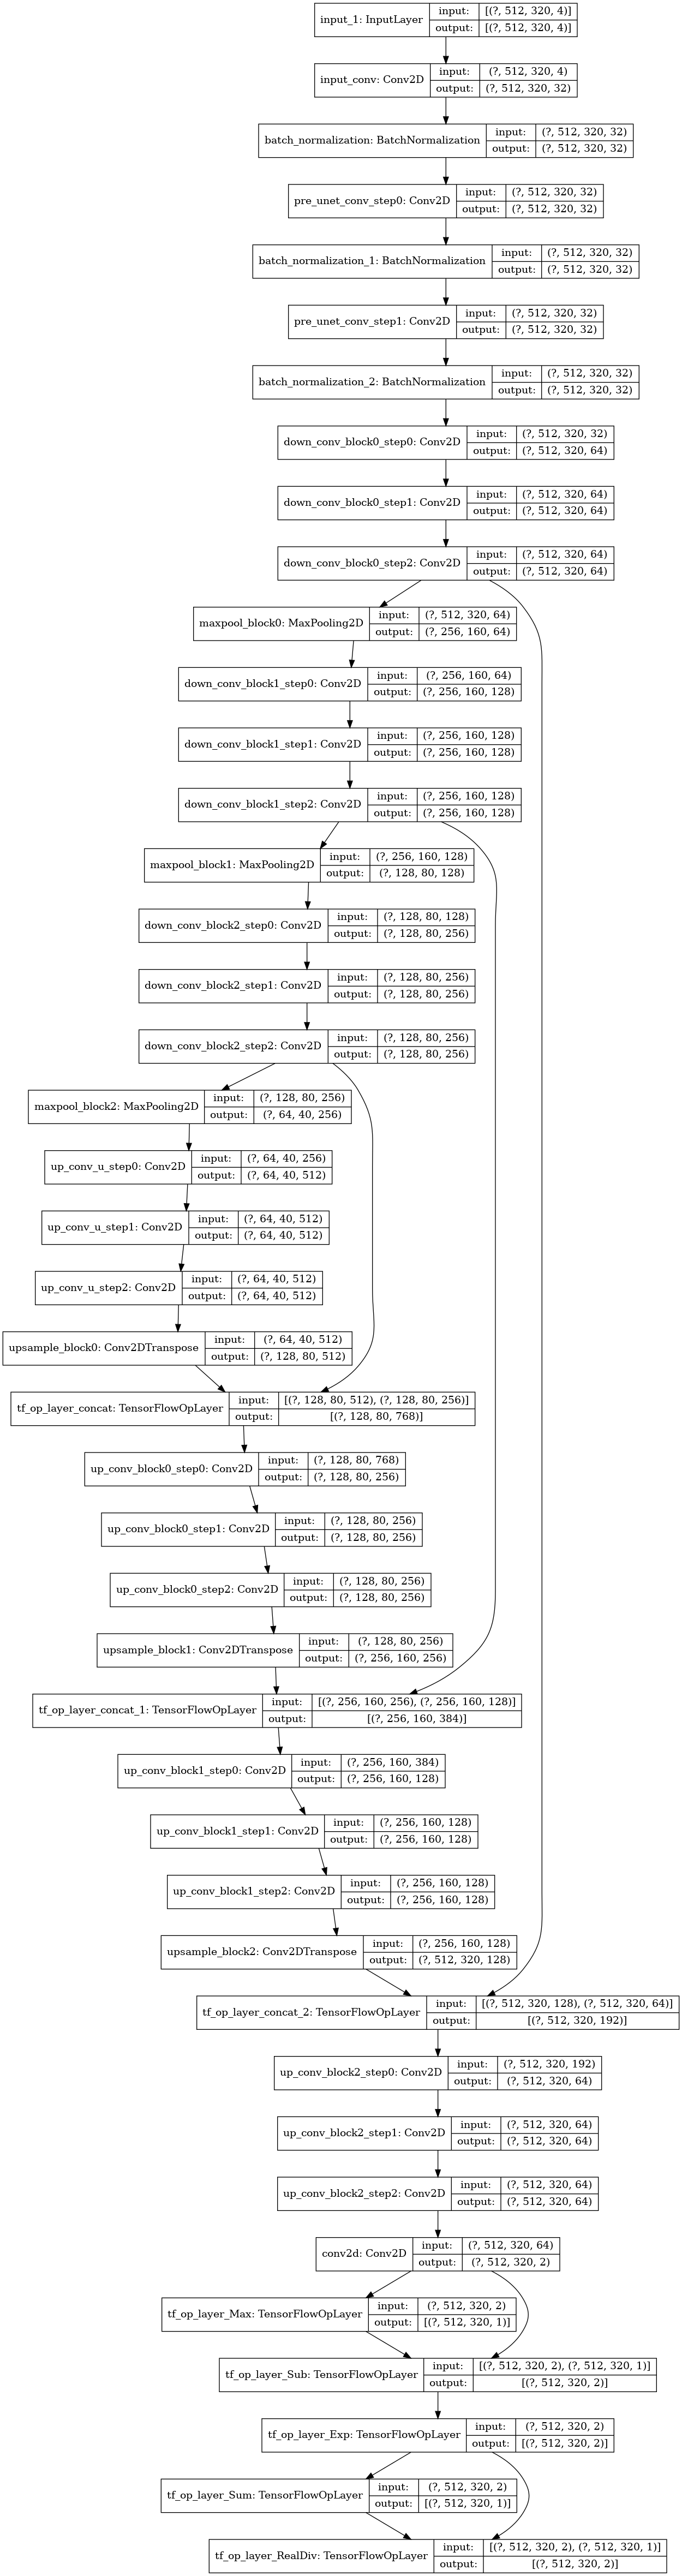

In [5]:
tf.keras.utils.plot_model(model.unet, show_shapes=True)

In [6]:
BATCH_SIZE = 4
BUFFER_SIZE = 6

train_dataset =  train_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset =  val_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

model.unet.fit(
    train_dataset, epochs=10, validation_data=val_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/10
  1/168 [..............................] - ETA: 0s - loss: 0.0938 - accuracy: 0.9710WARNING:tensorflow:From /home/yao/develop/channel_image_segmentation/.venv/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
168/168 [==============================] - 160s 953ms/step - loss: 0.0862 - accuracy: 0.9750 - val_loss: 0.0874 - val_accuracy: 0.9746
Epoch 2/10
168/168 [==============================] - 161s 959ms/step - loss: 0.0834 - accuracy: 0.9747 - val_loss: 0.0863 - val_accuracy: 0.9748
Epoch 3/10
168/168 [==============================] - 160s 954ms/step - loss: 0.0855 - accuracy: 0.9748 - val_loss: 0.0866 - val_accuracy: 0.9749
Epoch 4/10
168/168 [==============================] - 160s 955ms/step - loss: 0.0867 - accuracy: 0.9747 - val_loss: 0.0820 - val_accuracy: 0.9749
Epoch 5/10
168

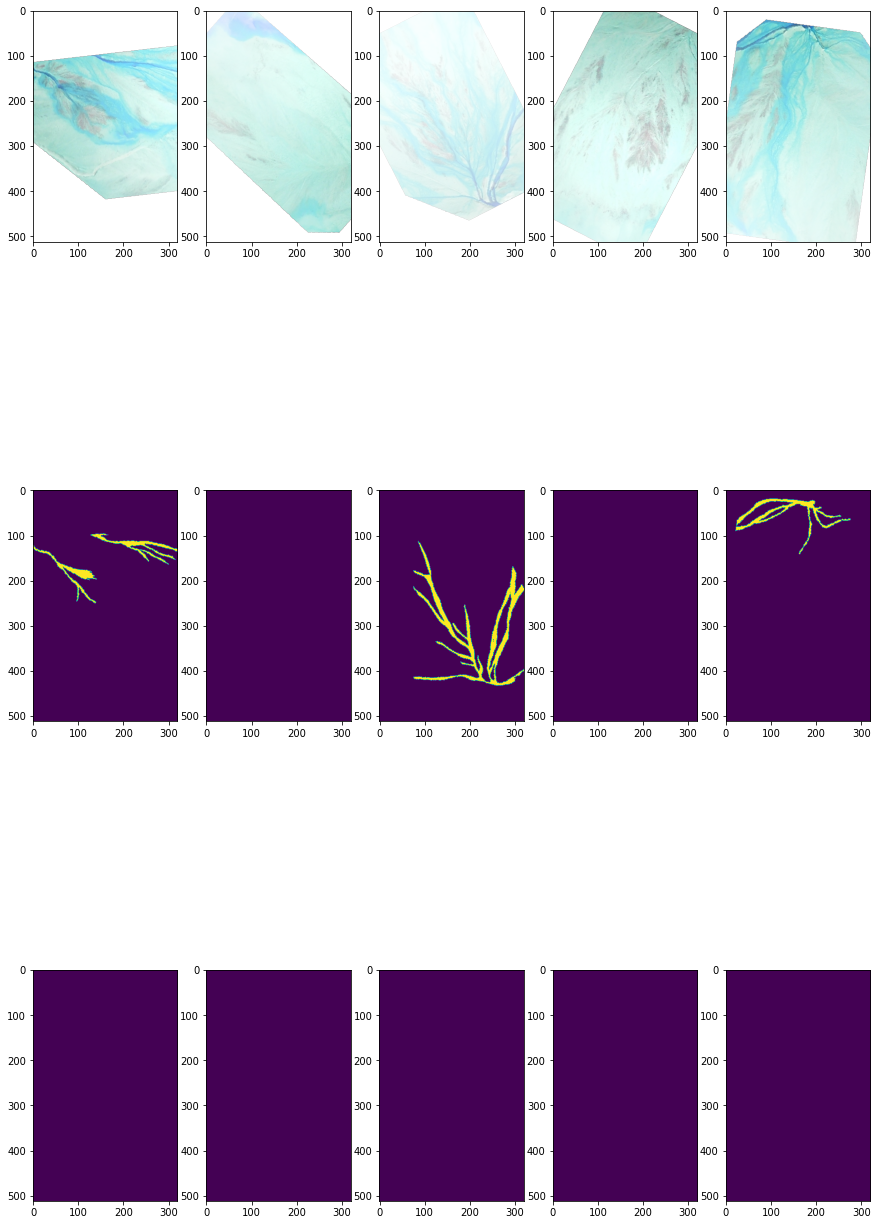

In [7]:
n_samples = 5

fig, axes = plt.subplots(nrows=3, ncols=n_samples, figsize=(15, n_samples*5))
i = 0
for x, y in val_dataset.take(5):
    axes[0][i].imshow(x[0, :, : :])
    axes[1][i].imshow(y[0, :, : :])
    axes[2][i].imshow(model.unet.predict(x)[0, :, :, 1])
    i += 1
    
plt.show()